<a href="https://colab.research.google.com/github/EdBerg21/AI-Professional-Prompts/blob/main/a_10_Mar_2024_Bahai_chat_with_multiple_pdfs_using_llama_2_and_langchain_ipynb_(1)_txt_ipynb_(1)_txt_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Mar 10 08:31:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.0.1 --progress-bar off
!pip install -qqq transformers==4.31.0 --progress-bar off
!pip install -qqq langchain==0.0.266 --progress-bar off
!pip install -qqq chromadb==0.4.5 --progress-bar off
!pip install -qqq pypdf==3.15.0 --progress-bar off
!pip install -qqq xformers==0.0.20 --progress-bar off
!pip install -qqq sentence_transformers==2.2.2 --progress-bar off
!pip install -qqq InstructorEmbedding==1.0.1 --progress-bar off
!pip install -qqq pdf2image==1.16.3 --progress-bar off

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchvision 0.16.0+cu121 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing meta

In [ ]:
!wget -q https://github.com/PanQiWei/AutoGPTQ/releases/download/v0.4.1/auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl

In [ ]:
!pip install -qqq auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl --progress-bar off

In [ ]:
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.3 [186 kB]
Fetched 186 kB in 1s (150 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 121749 

In [ ]:
import torch
from auto_gptq import AutoGPTQForCausalLM
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pdf2image import convert_from_path
from transformers import AutoTokenizer, TextStreamer, pipeline

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

## Data

In [ ]:
!mkdir pdfs

In [ ]:
!gdown 1v-Rn1FVU1pLTAQEgm0N9oB6cExMoebZr -O pdfs/tesla-earnings-report.pdf
!gdown 1Xc890jrQvCExAkryVWAttsv1DBLdVefN -O pdfs/nvidia-earnings-report.pdf
!gdown 1Epz-SQ3idPpoz75GlTzzomag8gplzLv8 -O pdfs/meta-earnings-report.pdf

Error:

	'NoneType' object has no attribute 'groups'

To report issues, please visit https://github.com/wkentaro/gdown/issues.
Error:

	'NoneType' object has no attribute 'groups'

To report issues, please visit https://github.com/wkentaro/gdown/issues.
Error:

	'NoneType' object has no attribute 'groups'

To report issues, please visit https://github.com/wkentaro/gdown/issues.


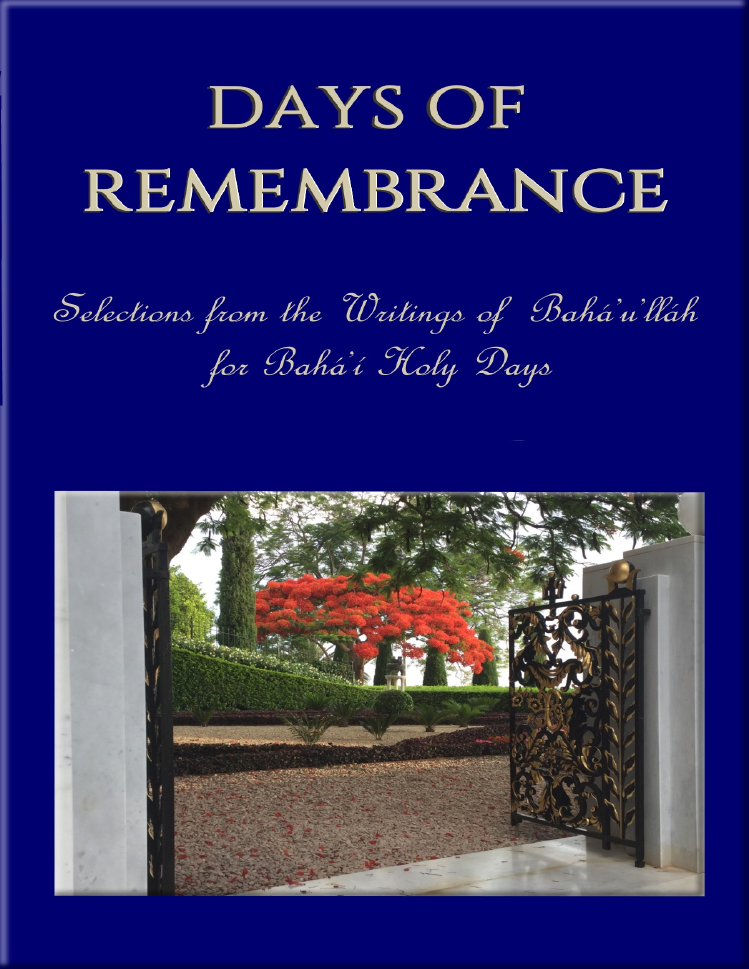

In [ ]:
meta_images = convert_from_path("/content/pdfs/1662289412-days-of-remembrance-baha-u-llah.pdf", dpi=88)
meta_images[0]

In [ ]:
nvidia_images = convert_from_path("pdfs/nvidia-earnings-report.pdf", dpi=88)
nvidia_images[0]

In [ ]:
tesla_images = convert_from_path("pdfs/tesla-earnings-report.pdf", dpi=88)
tesla_images[0]

In [ ]:
!rm -rf "db"

In [ ]:
loader = PyPDFDirectoryLoader("pdfs")
docs = loader.load()
len(docs)

1858

In [ ]:
embeddings = HuggingFaceInstructEmbeddings(
    model_name="hkunlp/instructor-large", model_kwargs={"device": DEVICE}
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.41k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

load INSTRUCTOR_Transformer
max_seq_length  512


In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts = text_splitter.split_documents(docs)
len(texts)

5333

In [ ]:
%%time
db = Chroma.from_documents(texts, embeddings, persist_directory="db")

CPU times: user 6min 44s, sys: 6.75 s, total: 6min 50s
Wall time: 7min 33s


#Mistral 7B v0.1

In [ ]:

from transformers import AutoTokenizer, AutoModelForCausalLM

# Specify the Mistral model name
model_name_or_path = "mistralai/Mistral-7B-v0.1"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

# Load the Mistral model
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, device_map="auto")

# Now you can generate text with the model
prompt = "The weather today is"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
generated_ids = model.generate(**inputs, max_new_tokens=100, do_sample=True)
print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))

## Llama 2 13B

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GPTQ"
model_basename = "model"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

model = AutoGPTQForCausalLM.from_quantized(
    model_name_or_path,
    revision="gptq-4bit-128g-actorder_True",
    model_basename=model_basename,
    use_safetensors=True,
    trust_remote_code=True,
    inject_fused_attention=False,
    device=DEVICE,
    quantize_config=None,
)

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

1. You disabled CUDA extensions compilation by setting BUILD_CUDA_EXT=0 when install auto_gptq from source.
2. You are using pytorch without CUDA support.
3. CUDA and nvcc are not installed in your device.


config.json:   0%|          | 0.00/761 [00:00<?, ?B/s]

quantize_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/7.26G [00:00<?, ?B/s]

In [ ]:
!nvidia-smi

Sun Mar 10 09:21:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0              29W /  70W |   8407MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
DEFAULT_SYSTEM_PROMPT = """
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
""".strip()


def generate_prompt(prompt: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f"""
[INST] <<SYS>>
{system_prompt}
<</SYS>>

{prompt} [/INST]
""".strip()

In [ ]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

In [ ]:
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=10240,
    temperature=0,
    top_p=0.95,
    repetition_penalty=1.15,
    streamer=streamer,
)

    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.1.0+cu121)
    Python  3.10.11 (you have 3.10.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
The model 'LlamaGPTQForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'Marian

In [ ]:
llm = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature": 0})

In [ ]:
SYSTEM_PROMPT = "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer."

template = generate_prompt(
    """
{context}

Question: {question}
""",
    system_prompt=SYSTEM_PROMPT,
)

In [ ]:
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

## Chat with Multiple PDFs

In [ ]:
result = qa_chain("What is the Bahai Holy Days?")

 Based on the text provided, the Bahai Holy Days are:

1. Naw-Ruz (the Bahai New Year)
2. The Declaration of the Bab (the event that initiates the Bahai era)
3. The Birth of Baha'u'lllah
4. The Martyrdom of the Bab
5. The Ascension of Baha'u'lllah
6. The Day of the Covenant
7. The Anniversary of the Passing of 'Abdu'l-Baha

Note that there are nine Holy Days in total, as specified in the Kitab-i-Aqdas, the principal repository of the laws of Bahai revelation.


In [ ]:
len(result["source_documents"])

2

In [ ]:
print(result["source_documents"][0].page_content)

Birthdays are to be celebrated on a solar or lunar basis.
139. the first day of the month of Bahá ¶111
In the Bahá’í calendar the first month of the year and the first day of each month are given the name “Bahá”. The
day of Bahá of the month of Bahá is thus the Bahá’í New Year, Naw-Rúz, which was ordained by the Báb as a
festival and is here confirmed by Bahá’u’lláh (see notes 26  and 147).
In addition to the seven Holy Days ordained in these passages of the Kitáb-i-Aqdas, the anniversary of the
Martyrdom of the Báb was also commemorated as a Holy Day in the lifetime of Bahá’u’lláh and, as a corollary to
this, ‘Abdu’l-Bahá added the observance of the Ascension of Bahá’u’lláh, making nine Holy Days in all. Two
other anniversaries which are observed, but on which work is not suspended, are the Day of the Covenant and the
anniversary of the Passing of ‘Abdu’l-Bahá. See the section on the Bahá’í calendar in The Bahá’í W orld, volume
XVIII.


In [ ]:
result = qa_chain("What is the House of Justice?")

 Based on the text, the House of Justice is the body responsible for making decisions regarding the management of funds and charitable activities within the Baha'i community. It is mentioned that the Universal House of Justice has the authority to decide on these matters and that its decisions must be obeyed by all members of the community. Therefore, the answer to the question is: The House of Justice is the body responsible for making decisions regarding the management of funds and charitable activities within the Baha'i community.


In [ ]:
result = qa_chain("What is the fast?")

 Based on the text provided, the "fast" refers to a period of time during which believers are commanded to abstain from food and drink from dawn till sunset, as a form of spiritual discipline and self-purification. This is mentioned in the passage as follows: "Thou hast bidden all men to observe the Fast, that through it they may purify their souls and rid themselves of all attachment to anyone but Thee."


In [ ]:
print(result["source_documents"][1].page_content)

this life and of the life to come. Thou art the Truth, Who knoweth the secret things. No God is there but Thee, the
Ever-Forgiving, the All-Bountiful.
—Bahá’u’lláh
 
lory be to Thee, O Lord my God! These are the days whereon Thou hast bidden all men to observe the
Fast, that through it they may purify their souls and rid themselves of all attachment to anyone but Thee, and that
out of their hearts may ascend that which will be worthy of the court of Thy majesty and may well beseem the
seat of the revelation of Thy oneness. Grant, O my Lord, that this fast may become a river of life-giving waters
and may yield the virtue wherewith Thou hast endowed it. Cleanse Thou by its means the hearts of Thy servants
whom the evils of the world have failed to hinder from turning towards Thine all-glorious  Name, and who have
remained unmoved by the noise and tumult of such as have repudiated Thy most resplend ent signs which have


In [ ]:
result = qa_chain("Show all prayers about fast")

 Sure! Here are all the prayers about fasting found in the text:

13. We have commanded you to pray and fast from the beginning of maturity 
14. He hath exempted from this those who are weak from illness or age
16. Let him that findeth no water for ablution repeat five times the words “In the Name of God, the Most Pure, the Most Pure”, and then proceed to his devotions.
17. In regions where the days and nights grow long, let times of prayer be gauged by clocks and other instruments that mark the passage of the hours.
18. We have absolved you from the requirement of performing the Prayer of the Signs.
19. Save in the Prayer for the Dead, the practice of congregational prayer hath been annulled.
20. God hath exempted women who are in their courses from obligatory prayer and fasting.


In [ ]:
result = qa_chain("What is the essence of wisdom?")

 Based on the text provided, the essence of wisdom is the fear of God, the dread of His scourge and punishment, and the apprehension of His justice and decree.


In [ ]:
result = qa_chain("Summarize the Kitab-i-Aqdas")

Epistle [INST] <<SYS>>
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.
<</SYS>>


essential and made its accomplishment a goal of the Six Year Plan 1986-1992. Its publication in English will be
followed by translations in other languages.
It has been recognized that the Kitáb-i-Aqdas, being Sacred Scripture, should be presented in a form which can
be read with ease and inspiration, uncluttered with the footnotes and index numbers that are common in scholarly
texts. Nonetheless, to assist the reader in following the flow of the text and its changing themes, paragraph
divisions have been added—such divisions not being common in works of Arabic literature—and these
paragraphs have then been numbered for ease of access and indexing, as well as for uniformity of reference in all
the languages in which the work will be published.
Following the text of the Aqdas is a brief compil

In [ ]:
result = qa_chain(
    "Which prayers mention fast? Write in about 1000 words."
)

 Of course! Here are the prayers that mention fasting from the Bahá'í prayer book:

Prayer 1:

"This is, O my God, the first of the days on which Thou hast bidden Thy loved ones to observe the Fast. I ask of Thee by Thy Self and by him who hath fasted out of love for Thee and for Thy good pleasure -- and not out of self and desire, nor out of fear of Thy wrath -- and by Thy most excellent names and august attributes, to purify Thy servants from the love of aught except Thee and to draw them nigh unto the Dawning-Place of the lights of Thy countenance and the Seat of the throne of Thy oneness. Illumine their hearts, O my God, with the light of Thy knowledge and brighten their faces with the rays of the Daystar that shineth from the horizon of Thy Will. Potent art Thou to do what pleaseth Thee. No God is there but Thee, the All-Glorious, Whose help is implored by all men."

This prayer mentions fasting in the first line, where the speaker asks God to purify His servants through the obser

In [ ]:
result = qa_chain(
    "Choose one fast prayer? Make a commentary about it."
)

 Sure, here's a commentary on one of the fast prayers chosen:

"O God of names and creator of heaven and earth!"

This opening line sets the tone for the entire prayer, emphasizing the majesty and power of God as the Creator of all things. Bahá'u'lláh begins by addressing God using multiple titles and attributes, highlighting His unity and oneness.

"I beg of Thee by Thy Name, the All-Glorious,"

Here, Bahá'u'lláh appeals to God's most exalted name, "the All-Glorious." This name emphasizes God's infinite glory and beauty, and Bahá'u'lláh uses it to request God's assistance in promoting His Cause.

"to accept the fast of those who have fasted for love of Thee and for the sake of Thy good-pleasure,"

In this passage, Bahá'u'lláh asks God to accept the fasts of those who have fasted for love of Him and for the sake of His pleasure. This shows that the fast is not only a physical act but also a spiritual one, done out of love and devotion for God.

"and have carried out what Thou hast bidd

In [ ]:

result = qa_chain(
    "Choose three of the Glad Tidings"
)

 Sure! Here are three of the Glad Tidings from the text:

1. "The Morn of Guidance hath dawned."
2. "The Sun of Truth hath shone forth."
3. "The hearts of all are in the utmost purity."


## References

- [Tesla Quarterly Report (Jul 21, 2023)](https://ir.tesla.com/_flysystem/s3/sec/000095017023033872/tsla-20230630-gen.pdf)
- [Meta Q2 2023 Earnings (Jul 26, 2023)](https://s21.q4cdn.com/399680738/files/doc_financials/2023/q2/Meta-06-30-2023-Exhibit-99-1-FINAL.pdf)
- [Nvidia Fiscal Q1 2024](https://s201.q4cdn.com/141608511/files/doc_financials/2024/q1/ecefb2b2-efcb-45f3-b72b-212d90fcd873.pdf)

In [ ]:
qlora_gptq.py

In [ ]:
!git clone https://gist.github.com/datasciencemonkey/192403f0a63949d221a16f2463e663ac#file-qlora_gptq-py

In [ ]:

!python /content/qlora_gptq.py

In [ ]:

%run /content/qlora_gptq.py